# Micro rain radar (MRR) preparation for IPFS

In [3]:
import xarray as xr
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, AutoLocator
import yaml


## Prepare data

read config yaml which contains the data path and global attributes to be added to the dataset

In [21]:
with open("mrr_config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [22]:
data_path = config['paths']['data_path']
data_path_out = config['paths']['data_path_out']

read file list

In [6]:
file_list = glob.glob(data_path + 'M*/*/*.nc')

In [7]:
file_list.sort()

read example file

In [8]:
data0 = xr.open_dataset(file_list[2])#.Ze.isel(range=1).plot()

read individual files from file list with xarray and make a data list  
read only the reflectivity variable Ze

In [9]:
data_list = []
for file in file_list:
    data_list.append(xr.open_dataset(file).isel(range=slice(0,10)).Ze.drop_vars(['elevation', 'azimuth']))
    

concatenate the data list to one data fiele

In [11]:
data = xr.concat(data_list, dim='time')

In [13]:
data.sizes

Frozen({'time': 549995, 'range': 10})

## Find Ze threshold and radar range gate for rain flag definition  

plot Ze for two different time periods, before and after the rearrangement of the MRR

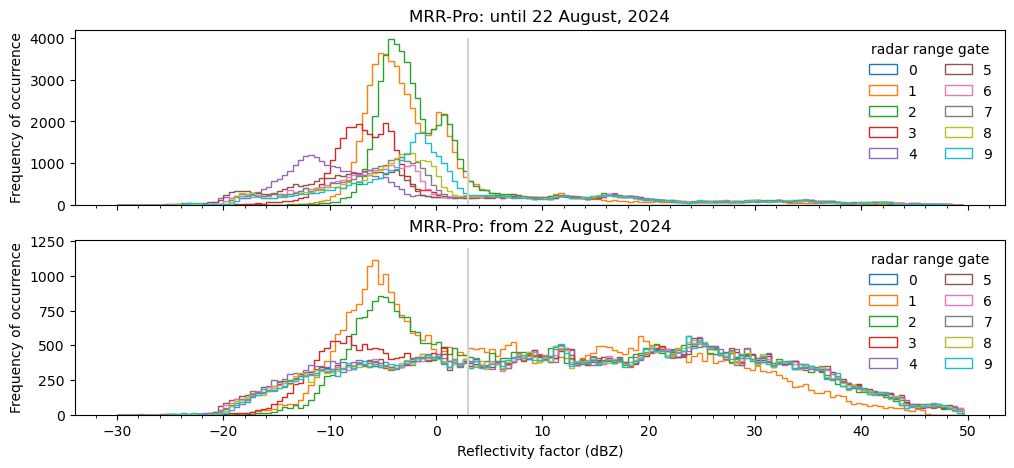

In [14]:
fig, ax = plt.subplots(nrows=2, figsize=(12,5), sharex=True)

for rr in range(0,10):
    data.isel(range=rr).sel(time=slice('2024-08-18T00:00', '2024-08-22T18:00')).plot.hist(bins=np.arange(-30,50,.5), histtype='step', label=rr, ax=ax[0])
    data.isel(range=rr).sel(time=slice('2024-08-22T18:00', '2024-09-22T12:00')).plot.hist(bins=np.arange(-30,50,.5), histtype='step', label=rr, ax=ax[1])

for axi in ax:
    axi.set_title('')
    axi.set_ylabel('Frequency of occurrence')
    axi.legend(ncols=2, frameon=False, title='radar range gate')
    #axi.set_ylim(0,4000)
    axi.set_xlabel('')
    axi.xaxis.set_minor_locator(AutoMinorLocator(5))

ax[0].vlines(3, 0, 4000, color='lightgray')
ax[1].vlines(3, 0, 1200, color='lightgray')
ax[0].set_title('MRR-Pro: until 22 August, 2024')
ax[1].set_title('MRR-Pro: from 22 August, 2024')
ax[1].set_xlabel('Reflectivity factor (dBZ)')


plt.savefig('MRR_Ze_lowest_radar_range_gate.png')

Ze threshold set to 3 dBZ

## Create rain flag

In [15]:
# Create a mask: 1 for finite values, 0 for NaNs
finite_mask = xr.where(data.isel(range=3) > 3, 1, 0)

# Create a Dataset with the mask as a new variable
dataset = xr.Dataset({"rain_flag": finite_mask})

# add attribute to variable
dataset['rain_flag'].attrs['note'] = '1 in case of rain'

## Add global attributes

In [16]:
global_attrs = config['global_attrs']
global_attrs

{'title': 'surface rain flag from Micro Rain Radar',
 'summary': 'Flag for rain occurence retrieved from the Micro Rain Radar measurement. Therefore, the observed reflectivity in secondlowest radar range gate (120m)?',
 'creator_name': 'Andreas Foth',
 'creator_email': 'andreas.foth@uni-leipzig.de',
 'license': 'CC BY 4.0',
 'project': 'BOWTIE',
 'platform': 'RV METEOR',
 'source': '',
 'history': '',
 'references': '',
 'processing_level': '',
 'institution': 'Leipzig Institute for Meteorology, Leipzig University',
 'instrument': 'METEK MRR Pro 1.2.5, ID: MRRPro27, METEK Serial Number:  0511107367, Software:  MRR Pro 1.2.5',
 'creator_id': 'ORCiD: 0000-0002-1164-3576',
 'convention': 'CF/Radial'}

In [17]:
for key, value in global_attrs.items():
    if key in dataset.attrs:
        # Fallunterscheidung je nach Typ des bestehenden Attributs
        if isinstance(dataset.attrs[key], str):
            dataset.attrs[key] += f"\n{value}"  # oder einfach + f", {value}" nach Geschmack
        elif isinstance(dataset.attrs[key], list):
            if isinstance(value, list):
                dataset.attrs[key].extend(value)
            else:
                dataset.attrs[key].append(value)
        else:
            # Für andere Typen: in Liste umwandeln und beide anhängen
            dataset.attrs[key] = [dataset.attrs[key], value]
    else:
        dataset.attrs[key] = value


In [25]:
dataset.attrs

{'title': 'surface rain flag from Micro Rain Radar',
 'summary': 'Flag for rain occurence retrieved from the Micro Rain Radar measurement. Therefore, the observed reflectivity in secondlowest radar range gate (120m)?',
 'creator_name': 'Andreas Foth',
 'creator_email': 'andreas.foth@uni-leipzig.de',
 'license': 'CC BY 4.0',
 'project': 'BOWTIE',
 'platform': 'RV METEOR',
 'source': '',
 'history': '',
 'references': '',
 'processing_level': '',
 'institution': 'Leipzig Institute for Meteorology, Leipzig University',
 'instrument': 'METEK MRR Pro 1.2.5, ID: MRRPro27, METEK Serial Number:  0511107367, Software:  MRR Pro 1.2.5',
 'creator_id': 'ORCiD: 0000-0002-1164-3576',
 'convention': 'CF/Radial'}

## Write dataset into netCDF

In [ ]:
dataset.to_netcdf('mrr_rainflag.nc')

## Write dataset into zarr

In [ ]:
dataset.to_zarr(data_path_out + "mrr_rainflag.zarr", mode="w")